---
title: "Supervised Learning"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 

In [1]:
#Questions: Which game factors most strongly predict placement?
#Does investing in high cost unit affect placement?

In [2]:
#import packages this file uses
import os
import re
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [3]:
#Import singlar combined csv file from raw data step as a pandas df
dfTFT = pd.read_csv("../data/processed-data/TFT_processed-data.csv")
dfTFT.head(5)

,match_id,puuid,placement,level,time_eliminated,total_damage,game_length,game_version,gold_left,traits,...,total_items,Release_Version,total_traits,total_units,top1,top4,bottom4,champions,raw_champions,champion_list
0,NA1_5412752266,zkxtkj27xwoevll2byguugjlpldforxw6vscn82z0s4m4w...,8,9,1591.827148,40,2182.824219,Linux Version 15.22.724.5161 (Nov 05 2025/16:1...,1,"[{'name': 'TFT15_Bastion', 'num_units': 1, 'st...",...,13,15.22,14,9,0,0,1,[],"['TFT15_Aatrox', 'TFT15_DrMundo', 'TFT15_Vi', ...","['Aatrox', 'DrMundo', 'Vi', 'Udyr', 'Sett', 'B..."
1,NA1_5412752266,5brr3jrvsrxprqoi2u1vdib7uhyvqh9dbldf7a1dv9_uvw...,1,9,2174.608154,173,2182.824219,Linux Version 15.22.724.5161 (Nov 05 2025/16:1...,61,"[{'name': 'TFT15_DragonFist', 'num_units': 1, ...",...,17,15.22,10,10,1,1,0,[],"['TFT15_Kayle', 'TFT15_Zac', 'TFT15_Aatrox', '...","['Kayle', 'Zac', 'Aatrox', 'Gangplank', 'Udyr'..."
2,NA1_5412752266,ilqfyw7mnea2shfj5mvz4yhh6whmkrhoqa8m8otzxvtn71...,6,9,1815.780273,80,2182.824219,Linux Version 15.22.724.5161 (Nov 05 2025/16:1...,0,"[{'name': 'TFT15_Bastion', 'num_units': 4, 'st...",...,11,15.22,9,10,0,0,1,[],"['TFT15_Ezreal', 'TFT15_Garen', 'TFT15_Rell', ...","['Ezreal', 'Garen', 'Rell', 'Rakan', 'Caitlyn'..."
3,NA1_5412752266,yja8q8aza0xq_s9hebroe4adddezonw0abvoc5gprzgmqw...,3,9,2032.849243,124,2182.824219,Linux Version 15.22.724.5161 (Nov 05 2025/16:1...,9,"[{'name': 'TFT15_Bastion', 'num_units': 2, 'st...",...,12,15.22,8,9,0,1,0,[],"['TFT15_Naafiri', 'TFT15_Lux', 'TFT15_XinZhao'...","['Naafiri', 'Lux', 'XinZhao', 'Viego', 'Samira..."
4,NA1_5412752266,oubcpr6kdwc2r4zz_msa6ftlulg14fqnrjj9pglbs2z4on...,5,8,1818.687256,84,2182.824219,Linux Version 15.22.724.5161 (Nov 05 2025/16:1...,41,"[{'name': 'TFT15_Bastion', 'num_units': 2, 'st...",...,13,15.22,7,8,0,0,1,[],"['TFT15_Ezreal', 'TFT15_Garen', 'TFT15_Syndra'...","['Ezreal', 'Garen', 'Syndra', 'Rakan', 'Malzah..."


In [4]:
#Only use Release Version 15.22
dfTFT = dfTFT[dfTFT["Release_Version"] == 15.22]

In [5]:
#get the champion as list from from field units
def get_champions(unit_entry):
    if isinstance(unit_entry, str):
        unit_list = ast.literal_eval(unit_entry)
        #remove the TFT15_ prefix
        return [u["character_id"].split("_", 1)[1] for u in unit_list]
    return []

dfTFT["champion_list"] = dfTFT["units"].apply(get_champions)
dfTFT["champion_list"].explode().unique()

array(['Aatrox', 'DrMundo', 'Vi', 'Udyr', 'Sett', 'Braum', 'leesin',
       'TwistedFate', 'Zyra', 'Kayle', 'Zac', 'Gangplank', 'Viego',
       'Ashe', 'JarvanIV', 'Galio', 'Ezreal', 'Garen', 'Rell', 'Rakan',
       'Caitlyn', 'Jayce', 'Neeko', 'Leona', 'Yuumi', 'Naafiri', 'Lux',
       'XinZhao', 'Samira', 'Volibear', 'Gwen', 'Syndra', 'Malzahar',
       'KSante', 'Lucian', 'Senna', 'Ryze', 'Karma', 'Yone', 'Kennen',
       'Ahri', 'Swain', 'smolder', 'Kalista', 'Kobuko', 'Shen', 'Jinx',
       'Poppy', 'Varus', 'Seraphine', 'Gnar', 'Xayah', 'Janna',
       'Katarina', 'Smolder', 'Sivir', 'Malphite', 'Ziggs', 'KogMaw',
       'Yasuo', 'rammus', 'Akali', 'Darius', 'kogmaw', 'Jhin', 'KaiSa',
       'Rammus', 'Ekko', nan, 'lulu'], dtype=object)

In [6]:
dfTFT.shape

(32455, 31)

In [7]:
#select the fields I want to use
#I did run time_eliminated,total_damage,game_length originally.
#They were most signifcant. 
#Makes sense because the player who lasted the longest and dealt the most damage should wins.

fields = ["level",
    "gold_left",
    "total_items",
    "num_units",
    "num_1star",
    "num_2star",
    "num_3star",
    "num_cost1",
    "num_cost2",
    "num_cost3",
    "num_cost4", 
    "num_cost5"]

X = dfTFT[fields]
Y = dfTFT["placement"]

In [8]:
#use train_test_split to train model
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42)

In [9]:
#estimators = itteration. More increases run time, ran state, no depth means trees fully capture interactions
rf = RandomForestRegressor(n_estimators = 600, random_state = 1, max_depth = None)
rf.fit(X_train, Y_train)
pred = rf.predict(X_test)

mae = mean_absolute_error(Y_test, pred)
print("MAE:", mae)

MAE: 1.1085405242013935


In [ ]:
#Despite deliberate omitted varaible bias, MAE is acceptable.

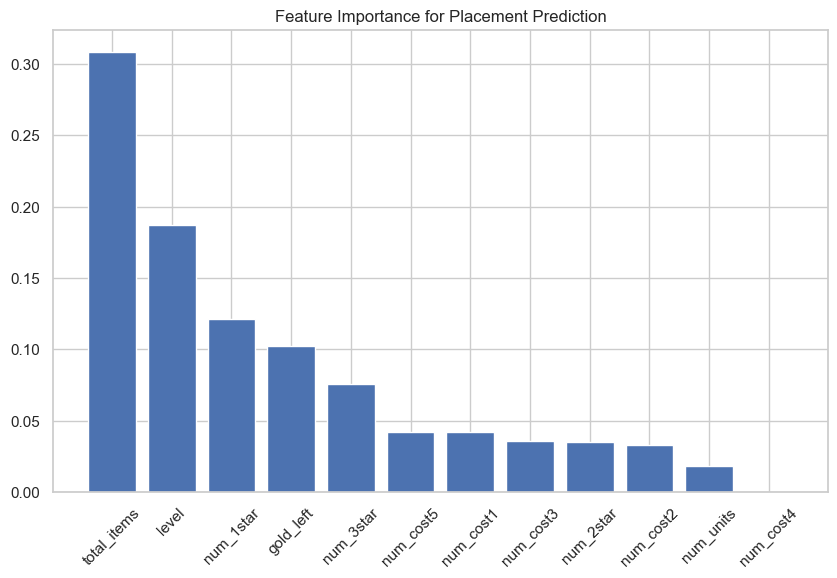

In [15]:
#plot results to see which features are most significant
import numpy as np
import matplotlib.pyplot as plt

importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.bar([fields[i] for i in indices], importances[indices])
plt.xticks(rotation=45)
plt.title("Feature Importance for Placement Prediction")
plt.show()

# Total_items is most significant by far. Follow by level and num_1star. 

# DSQ2: Does investing in high-cost units (4-5) affect placement? 

In [1]:
#Apply Ttest

dfTFT[["num_cost4", "num_cost5", "placement"]].corr()
top4_4cost = dfTFT[dfTFT["top4"] == 1]["num_cost4"]
bot4_4cost = dfTFT[dfTFT["top4"] == 0]["num_cost4"]
stats.ttest_ind(top4_4cost, bot4_4cost)

NameError: name 'dfTFT' is not defined

In [24]:
#TtestResult(statistic=nan, pvalue=nan, df=32453.0)
#Ttest is valid if Var = 0
print(top4_4cost.var())
print(bot4_4cost.var())

0.0
0.0


In [23]:
top4_5cost = dfTFT[dfTFT["top4"] == 1]["num_cost5"]
bot4_5cost = dfTFT[dfTFT["top4"] == 0]["num_cost5"]
stats.ttest_ind(top4_5cost, bot4_5cost)

TtestResult(statistic=17.90027055298418, pvalue=2.5873532044523514e-71, df=32453.0)